In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, TSNE
import matplotlib.pyplot as plt

def compute_PCA(x: np.ndarray) -> np.ndarray:
    pca = PCA(n_components=2)
    return pca.fit_transform(x)

def compute_MDS(x: np.ndarray) -> np.ndarray:
    mds = MDS(n_components=2)
    return mds.fit_transform(x)


def compute_Isomap(x: np.ndarray, n_neighbors: int = 30) -> np.ndarray:
    isomap = Isomap(n_components=2, n_neighbors=n_neighbors)
    return isomap.fit_transform(x)


def compute_tSNE(x: np.ndarray, perplexity: int = 50) -> np.ndarray:
    tsne = TSNE(n_components=2, perplexity=perplexity)
    return tsne.fit_transform(x)

In [27]:
emotions = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

methods = [
    ("MDS", compute_MDS),
    ("Isomap", compute_Isomap),
    ("t-SNE", compute_tSNE),
]

representations = np.load("output/dgcnn-xyz/val_representations.npy")
predictions = pd.read_csv("output/dgcnn-xyz/val_predictions.csv")

/home/patryk/anaconda3/envs/dnn/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/patryk/anaconda3/envs/dnn/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


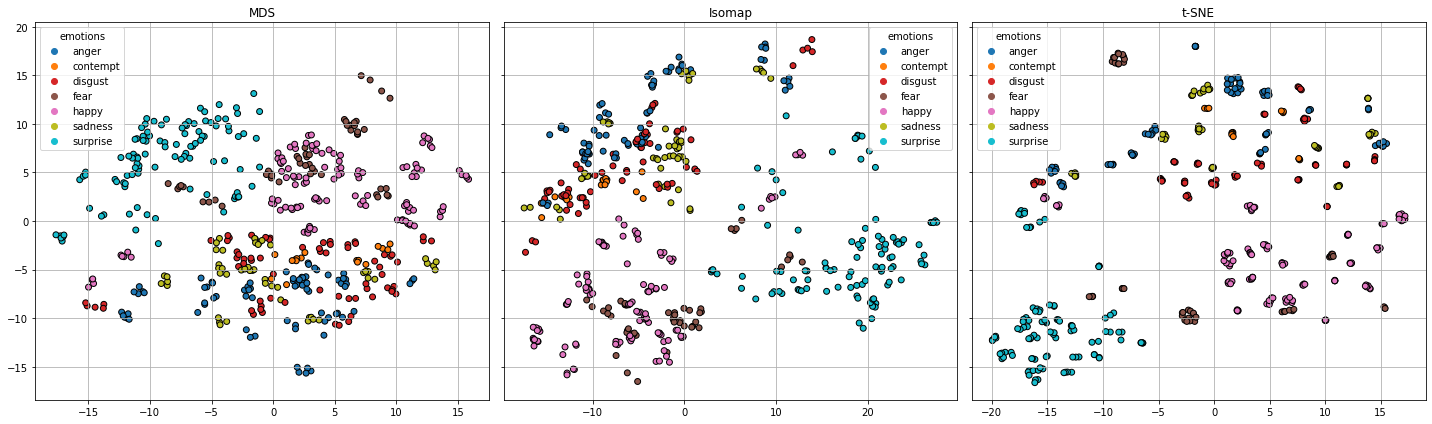

In [36]:
fig, axes = plt.subplots(ncols=len(methods), figsize=(20, 6), sharey=True)

for ax, (name, compute_fn) in zip(axes.flatten(), methods):
    z = compute_fn(x=representations)
    scatter = ax.scatter(
        z[:, 0], 
        z[:, 1], 
        c=predictions["true"].to_numpy(), 
        cmap="tab10", 
        s=35, 
        linewidths=1.0, 
        edgecolors=(0, 0, 0)
    )
    ax.set_title(name)
    ax.grid(zorder=-1)
    ax.legend(handles=scatter.legend_elements()[0], labels=emotions, title="emotions")
    
fig.tight_layout()